In [20]:
import pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [21]:
air_psg = pd.read_csv('C:\\Users\\jp\\Desktop\\testData\\AirPassengers.csv')

In [22]:
air_psg.head()

,Date,Monthly_flyers
0,2001/01/01,112
1,2001/02/01,118
2,2001/03/01,132
3,2001/04/01,129
4,2001/05/01,121


In [23]:
air_psg['Date'] = pd.to_datetime(air_psg['Date'], format = '%Y-%m-%d')
indexed_df = air_psg.set_index('Date')

In [25]:
indexed_df.head()

,Monthly_flyers
Date,
2001-01-01,112
2001-02-01,118
2001-03-01,132
2001-04-01,129
2001-05-01,121


In [24]:
ts = indexed_df['Monthly_flyers']
ts.head(5)

Date
2001-01-01    112
2001-02-01    118
2001-03-01    132
2001-04-01    129
2001-05-01    121
Name: Monthly_flyers, dtype: int64

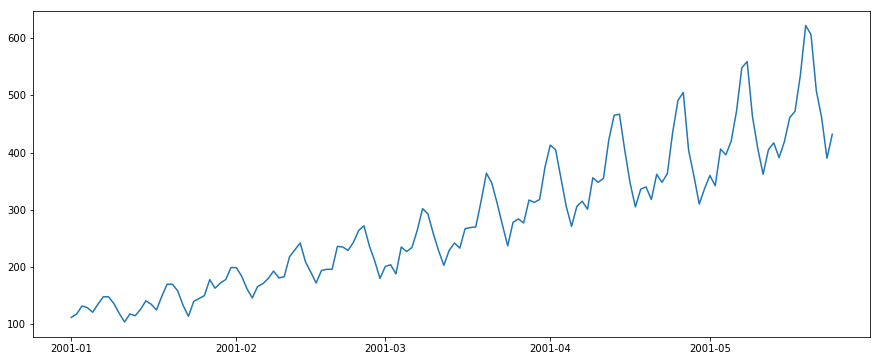

In [16]:
plt.plot(ts.index.to_pydatetime(), ts.values)

Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary.
The Second is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences

In [31]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.index.to_pydatetime(), rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

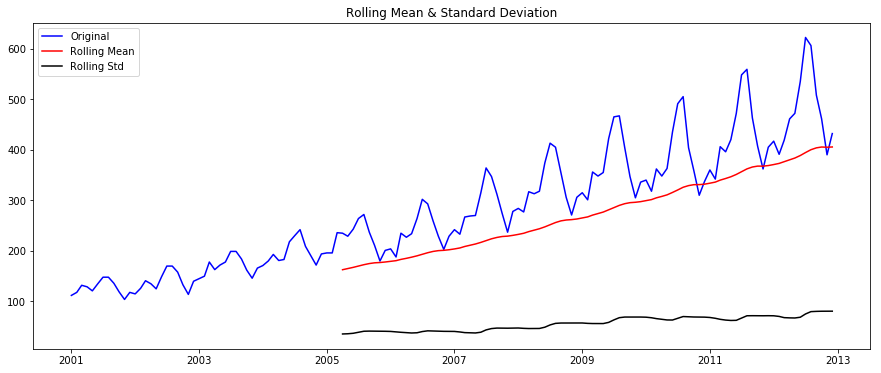

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [32]:
test_stationarity(ts)

p-value is larger than 0.05, the null hypothesis of the Dickey-Fuller test cannot be rejected.

## Stationarize the time series

## Apply the non linear log transformation

In [33]:
ts_log = np.log(ts)

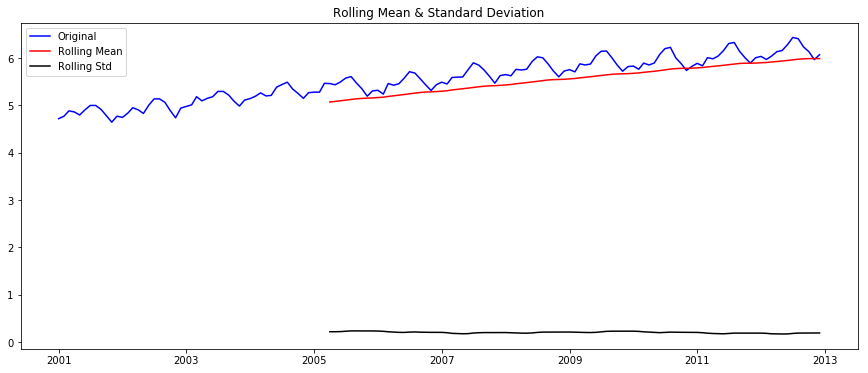

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [34]:
test_stationarity(ts_log)

In [55]:
# Applying differrencing 
ts_log_diff = ts_log - ts_log.shift()

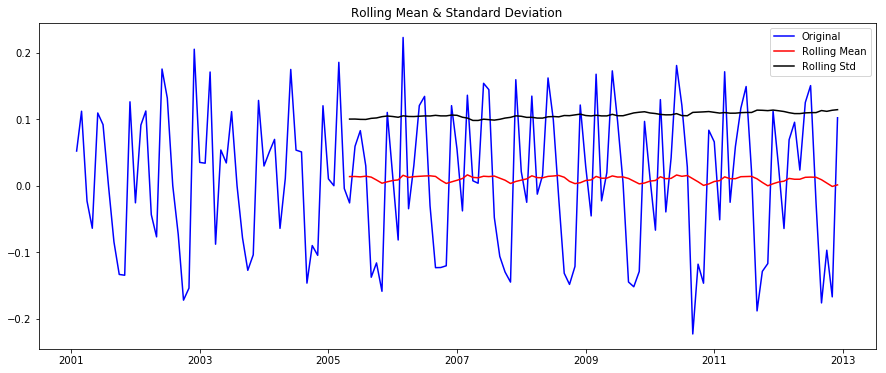

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [56]:
# test the stationarity on differrenced log data
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# ARIMA Model Building - Estimating the optimal ARIMA Model

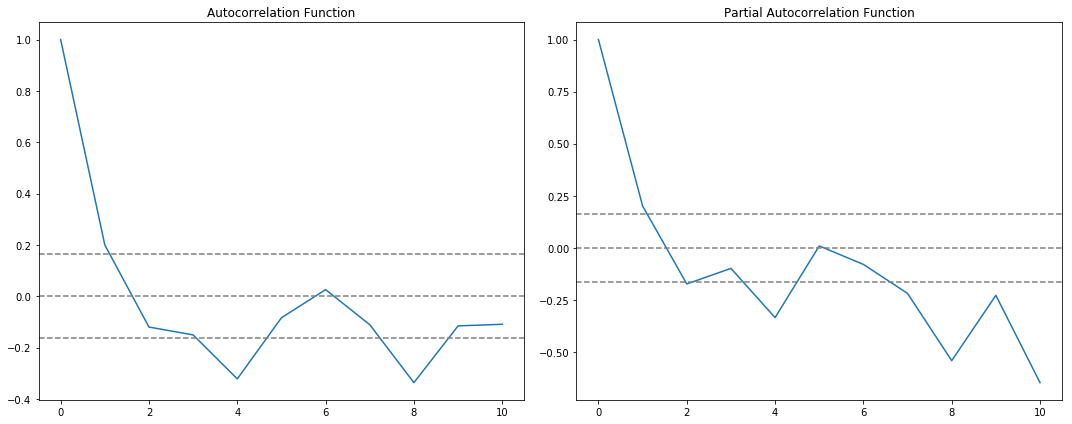

In [57]:
#ACF and PACF plots

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA(p,d,q)
- To apply an ARIMA model to your time series, you need to find optimal values for the following three model parameters (p,d,q):

- p: The lag value where the PACF cuts off (drops to 0) for the first time. 
- q: The lag value where the ACF chart crosses the upper confidence interval for the first time.

- The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable, the flyer freq, So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).


- The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value.

- The number of differences (d): These are the number of non-seasonal differences. In your case, d=1, as you are modeling using the first order differenced time series.

In [64]:
? model.fit()

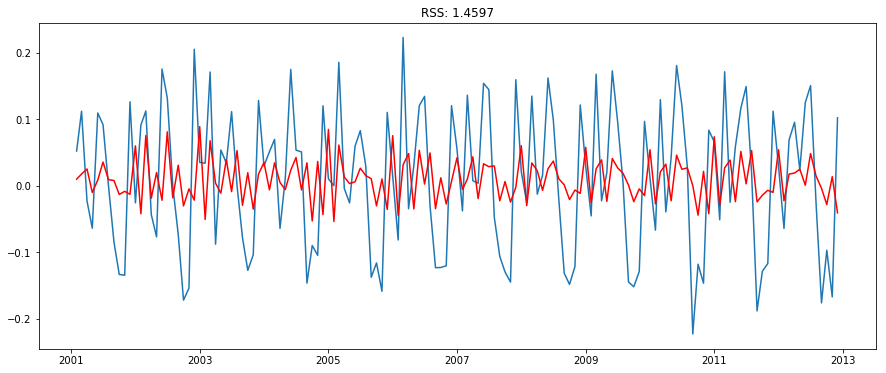

In [60]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)
plt.plot(ts_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:       D.Monthly_flyers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Thu, 30 Nov 2017   AIC                           -241.608
Time:                        02:50:09   BIC                           -229.756
Sample:                    02-01-2001   HQIC                          -236.792
                         - 12-01-2012                                         
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                      0.0098      0.010      0.993      0.322        -0.010     0.029
ar.L1.D.Monthly_flyers    -0.5826      0.128     -4.536      0.000        -0.834    -0.331
ma.L

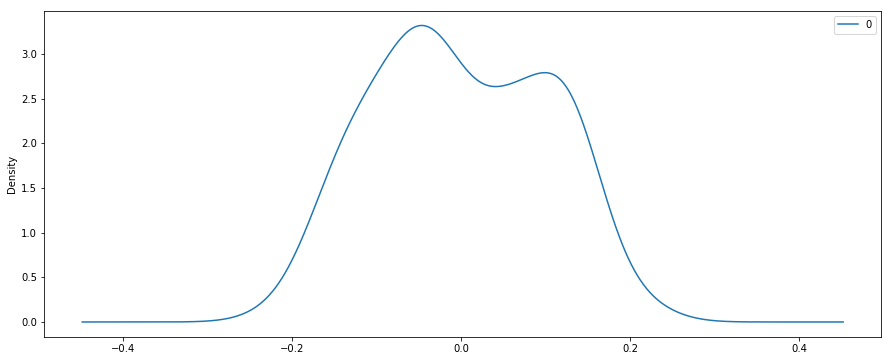

In [61]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [63]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2001-02-01    0.009800
2001-03-01    0.017618
2001-04-01    0.025229
2001-05-01   -0.010225
2001-06-01    0.008528
dtype: float64


In [66]:
model = ARIMA(ts_log, order=(1, 1, 1))  
model_fit = model.fit(disp=0) 
output = model_fit.forecast(10)
output

(array([ 6.14603748,  6.11633066,  6.14914714,  6.14553789,  6.16315006,
         6.16839875,  6.18085034,  6.18910556,  6.19980557,  6.20908125]),
 array([ 0.10097854,  0.16303769,  0.19794759,  0.23222552,  0.25962452,
         0.28568095,  0.3088579 ,  0.33078996,  0.3511486 ,  0.37050416]),
 array([[ 5.94812317,  6.34395178],
        [ 5.79678267,  6.43587866],
        [ 5.76117699,  6.53711729],
        [ 5.69038424,  6.60069153],
        [ 5.65429535,  6.67200478],
        [ 5.60847439,  6.72832312],
        [ 5.57549999,  6.7862007 ],
        [ 5.54076916,  6.83744197],
        [ 5.51156695,  6.88804418],
        [ 5.48290644,  6.93525606]]))